In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tpae.data.samples as tds
import tpae.data.patchcollection as tdp
import tpae.association as ta
import tpae.training as tt
import tpae.vis as tv
import gc, os
import scanpy as sc
import cna

import torch
torch.set_default_device('cuda') # for running on Yakir's macbook's GPU, change to cuda for O2

patchsize = 40; patchstride = 10
samplemeta = pd.read_csv('../uc-data/2024_10_16_UC_Patient_Metadata.csv').rename(columns={'NEW Label':'sid', 'Patient.ID':'donor'}).set_index('sid', drop=True)
samplemeta.donor = samplemeta.donor.astype('str')

In [2]:
def parser(fname): 
    fname = fname.split("/")[-1].split(".nc")[0]
    if len(fname.split("_")) == 2: 
        donor = fname.split("_")[1]
    else: 
        donor = fname
    return {'sid': fname, 'donor': donor}
    

In [3]:
repname = 'pca_k=10_harmony'
samples = tds.read_samples(f'../uc-data/10u/{repname}/*.nc', parser)
# samples = tds.read_samples(f'../uc-data/10u/{repname}/[0-9]*_*.nc', tds.default_parser)

100%|███████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.87it/s]


In [4]:
# choose which patches to train on
P = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
                        samples, standardize=True)
print(len(P), 'patches')

Pdense = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.5),
                        samples, standardize=True)
print(len(Pdense), 'dense patches')

100%|███████████████████████████████████████████████████████████████| 42/42 [00:17<00:00,  2.42it/s]


in pytorch mode
means: [ 0.09836863  0.3451774   0.06935897 -0.08409379 -0.09111391 -0.01477538
 -0.00389368  0.08767831 -0.01935403  0.05706252]
stds: [2.5323682  1.4590224  1.6672584  0.78581816 0.7659488  1.0015829
 0.8059369  0.67679024 0.7419386  0.6975653 ]
data augmentation is off
26925 patches


100%|███████████████████████████████████████████████████████████████| 42/42 [00:13<00:00,  3.00it/s]


in pytorch mode
means: [ 0.1326243   0.3794388   0.0971875  -0.10062593 -0.10492998 -0.01641472
 -0.00772433  0.10006809 -0.01495527  0.05235172]
stds: [2.6559796  1.5416566  1.762674   0.82376885 0.8035833  1.0635196
 0.8445268  0.71632814 0.77725774 0.73078877]
data augmentation is off
22300 dense patches


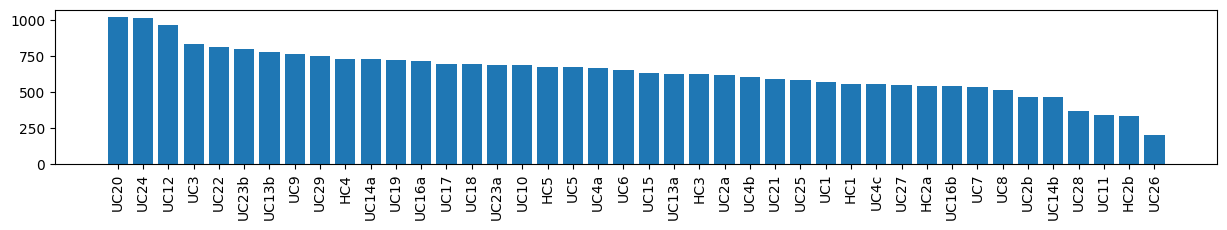

42it [00:10,  3.87it/s]


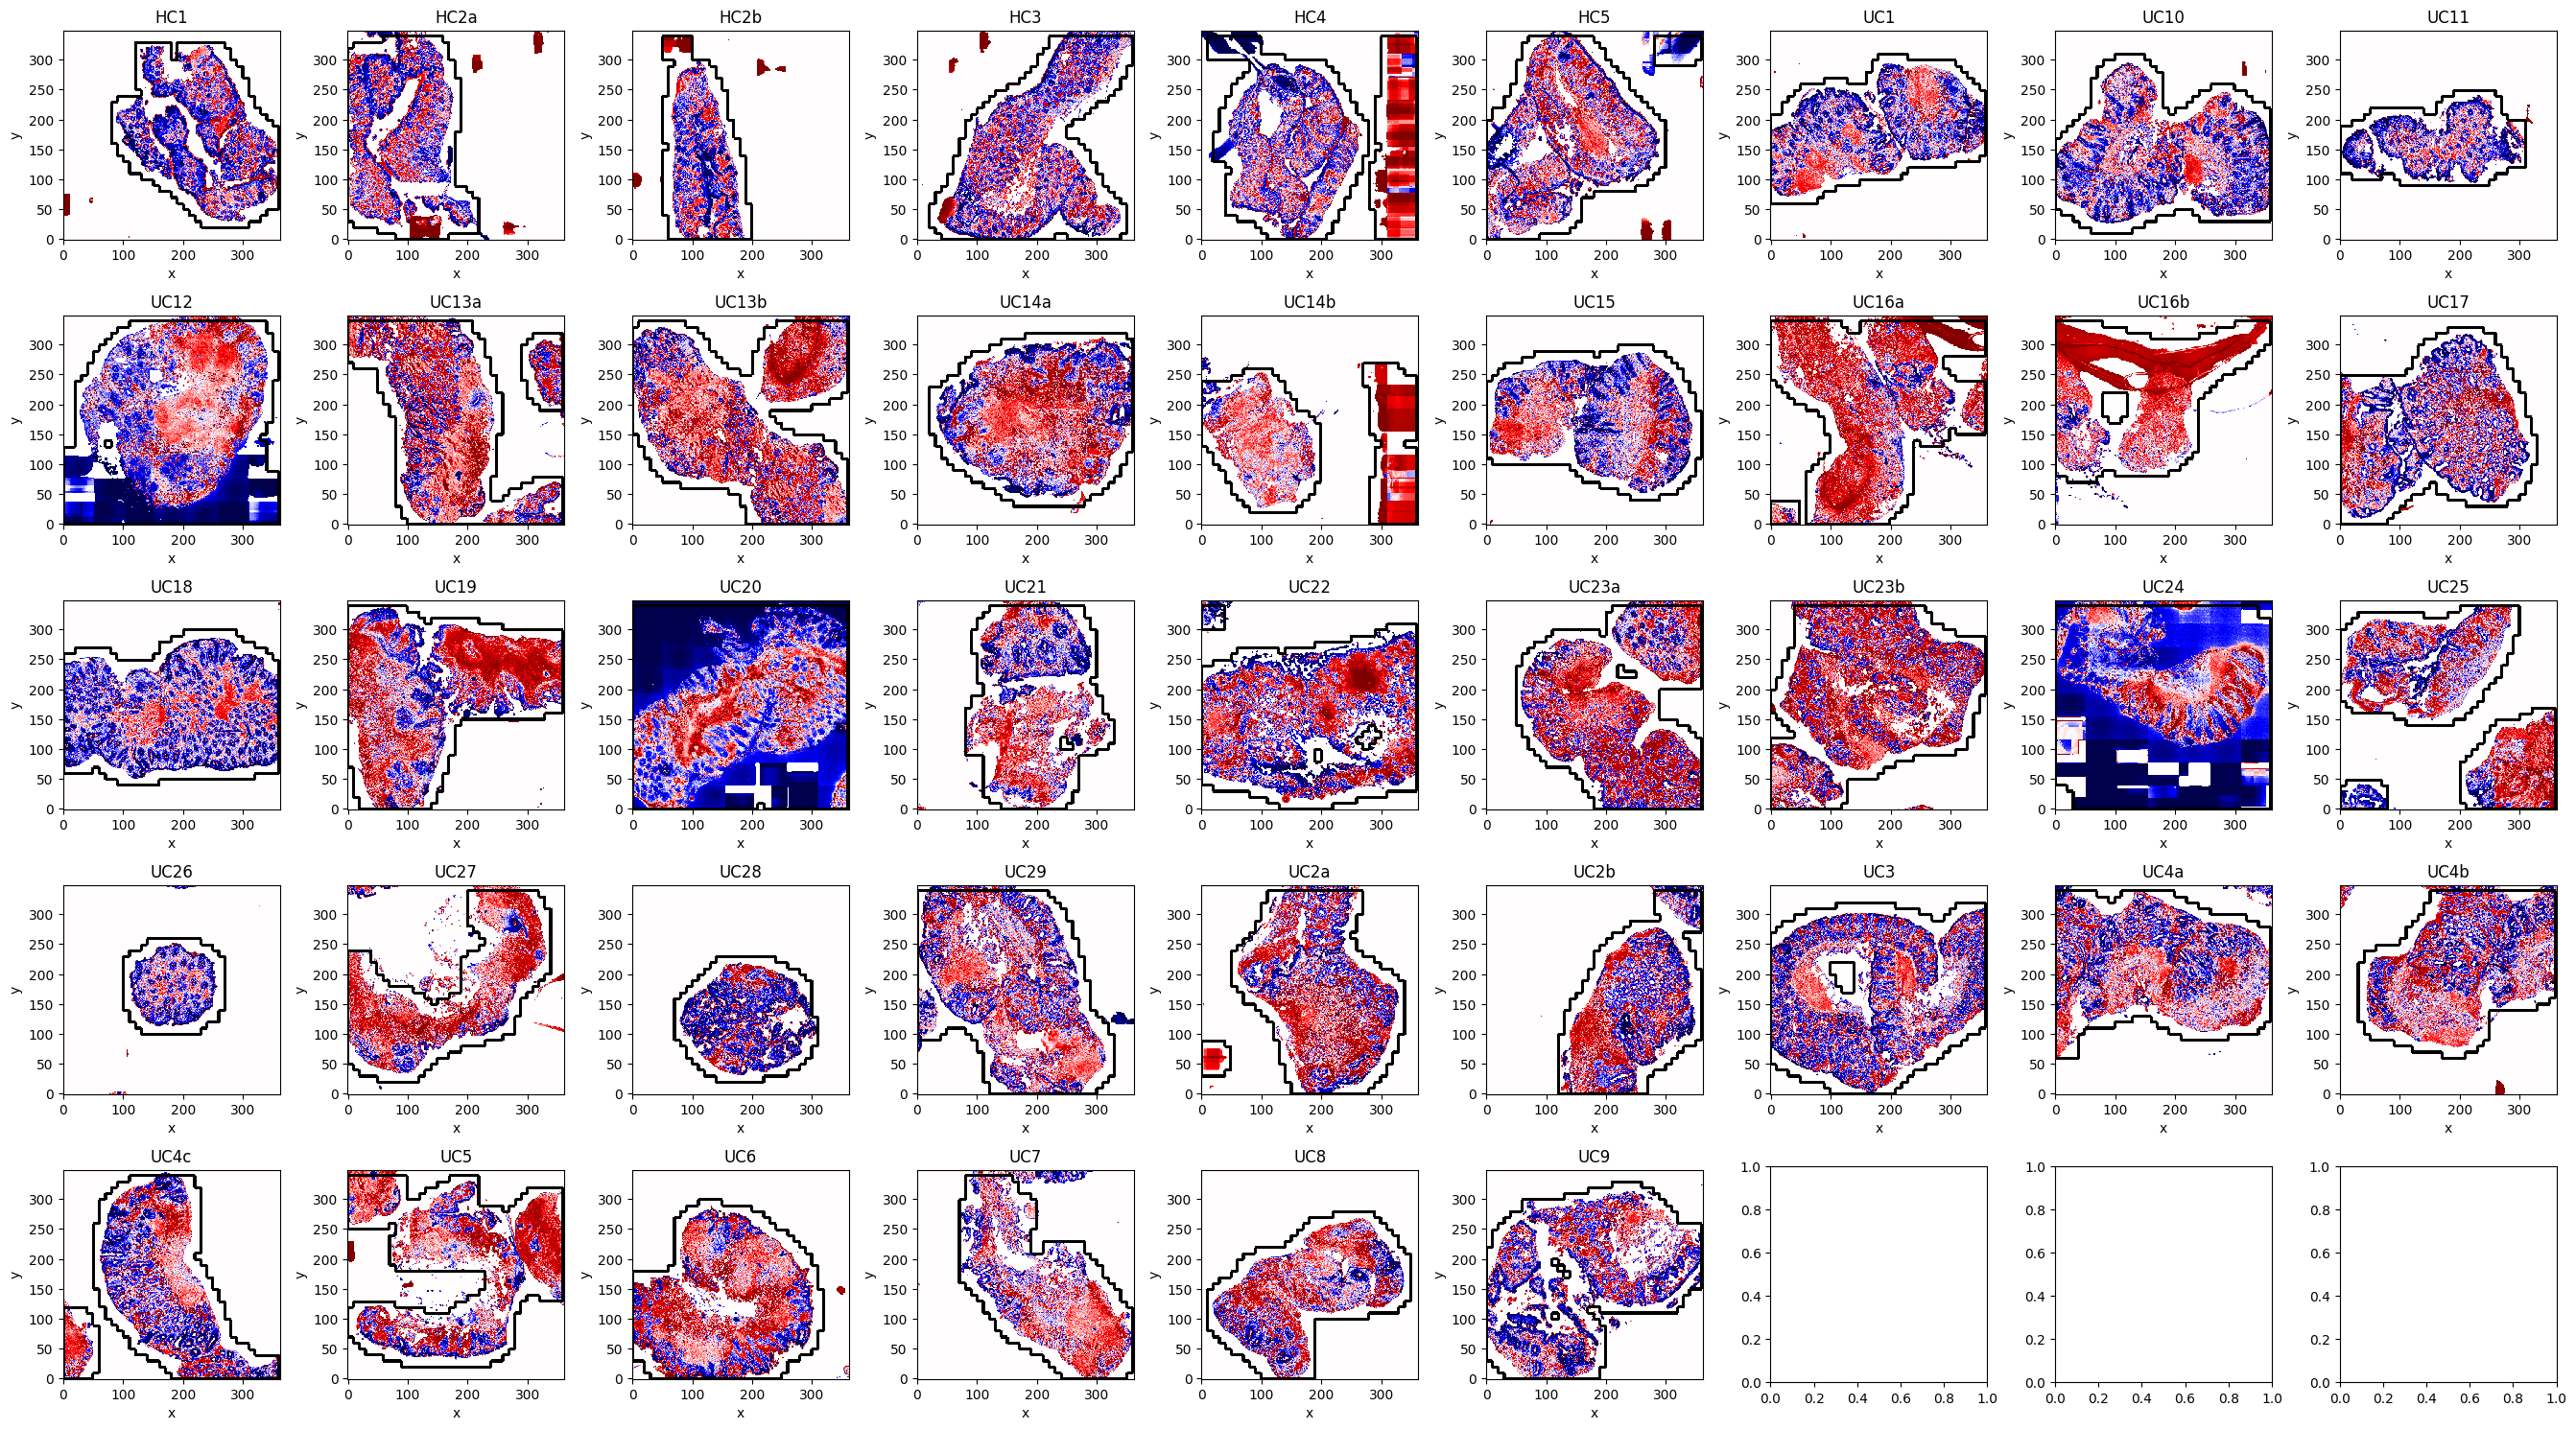

In [5]:
# visualize resulting patches
tds.plot_npatches_per_sample(samples, P.meta)
tds.plot_samples_with_patches(samples.values(), 'hPC1', Pdense.meta, ncols=9, vmin=-5, vmax=5, cmap='seismic')

# Create VAE representation

In [6]:
from tpae.models.resnet_vae import ResnetVAE
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels)
kl_weight = 1e-5
name = '3_kl1e-5'
os.makedirs(f'./models', exist_ok=True)

in pytorch mode
data augmentation is on


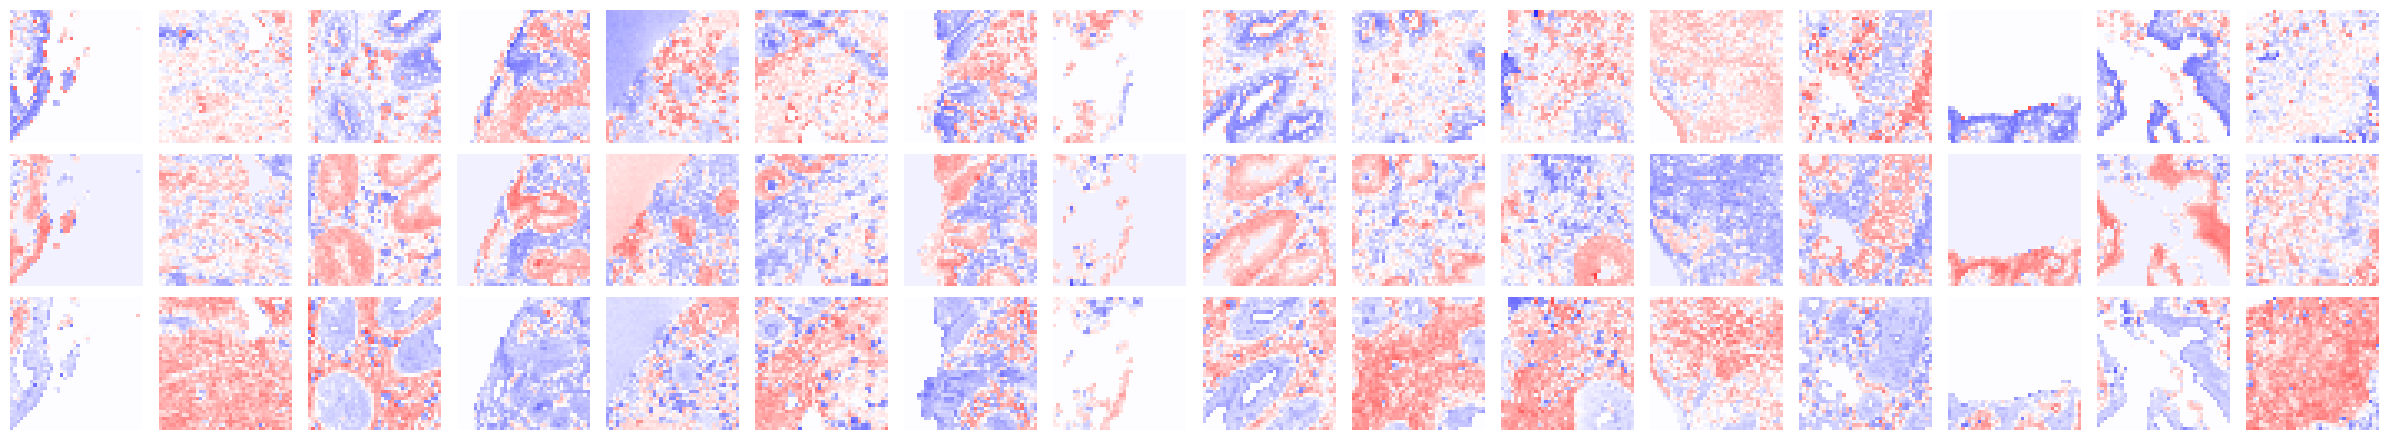

In [7]:
train_dataset, val_dataset = tt.train_test_split(P)
tv.plot_patches_separatechannels(val_dataset[:16][0].permute(0,2,3,1).cpu().numpy())

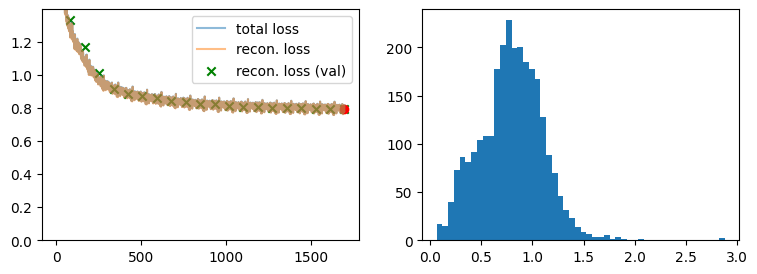

epoch 20. best validation reconstruction error = 0.7934420108795166
	total time: 12.424659729003906


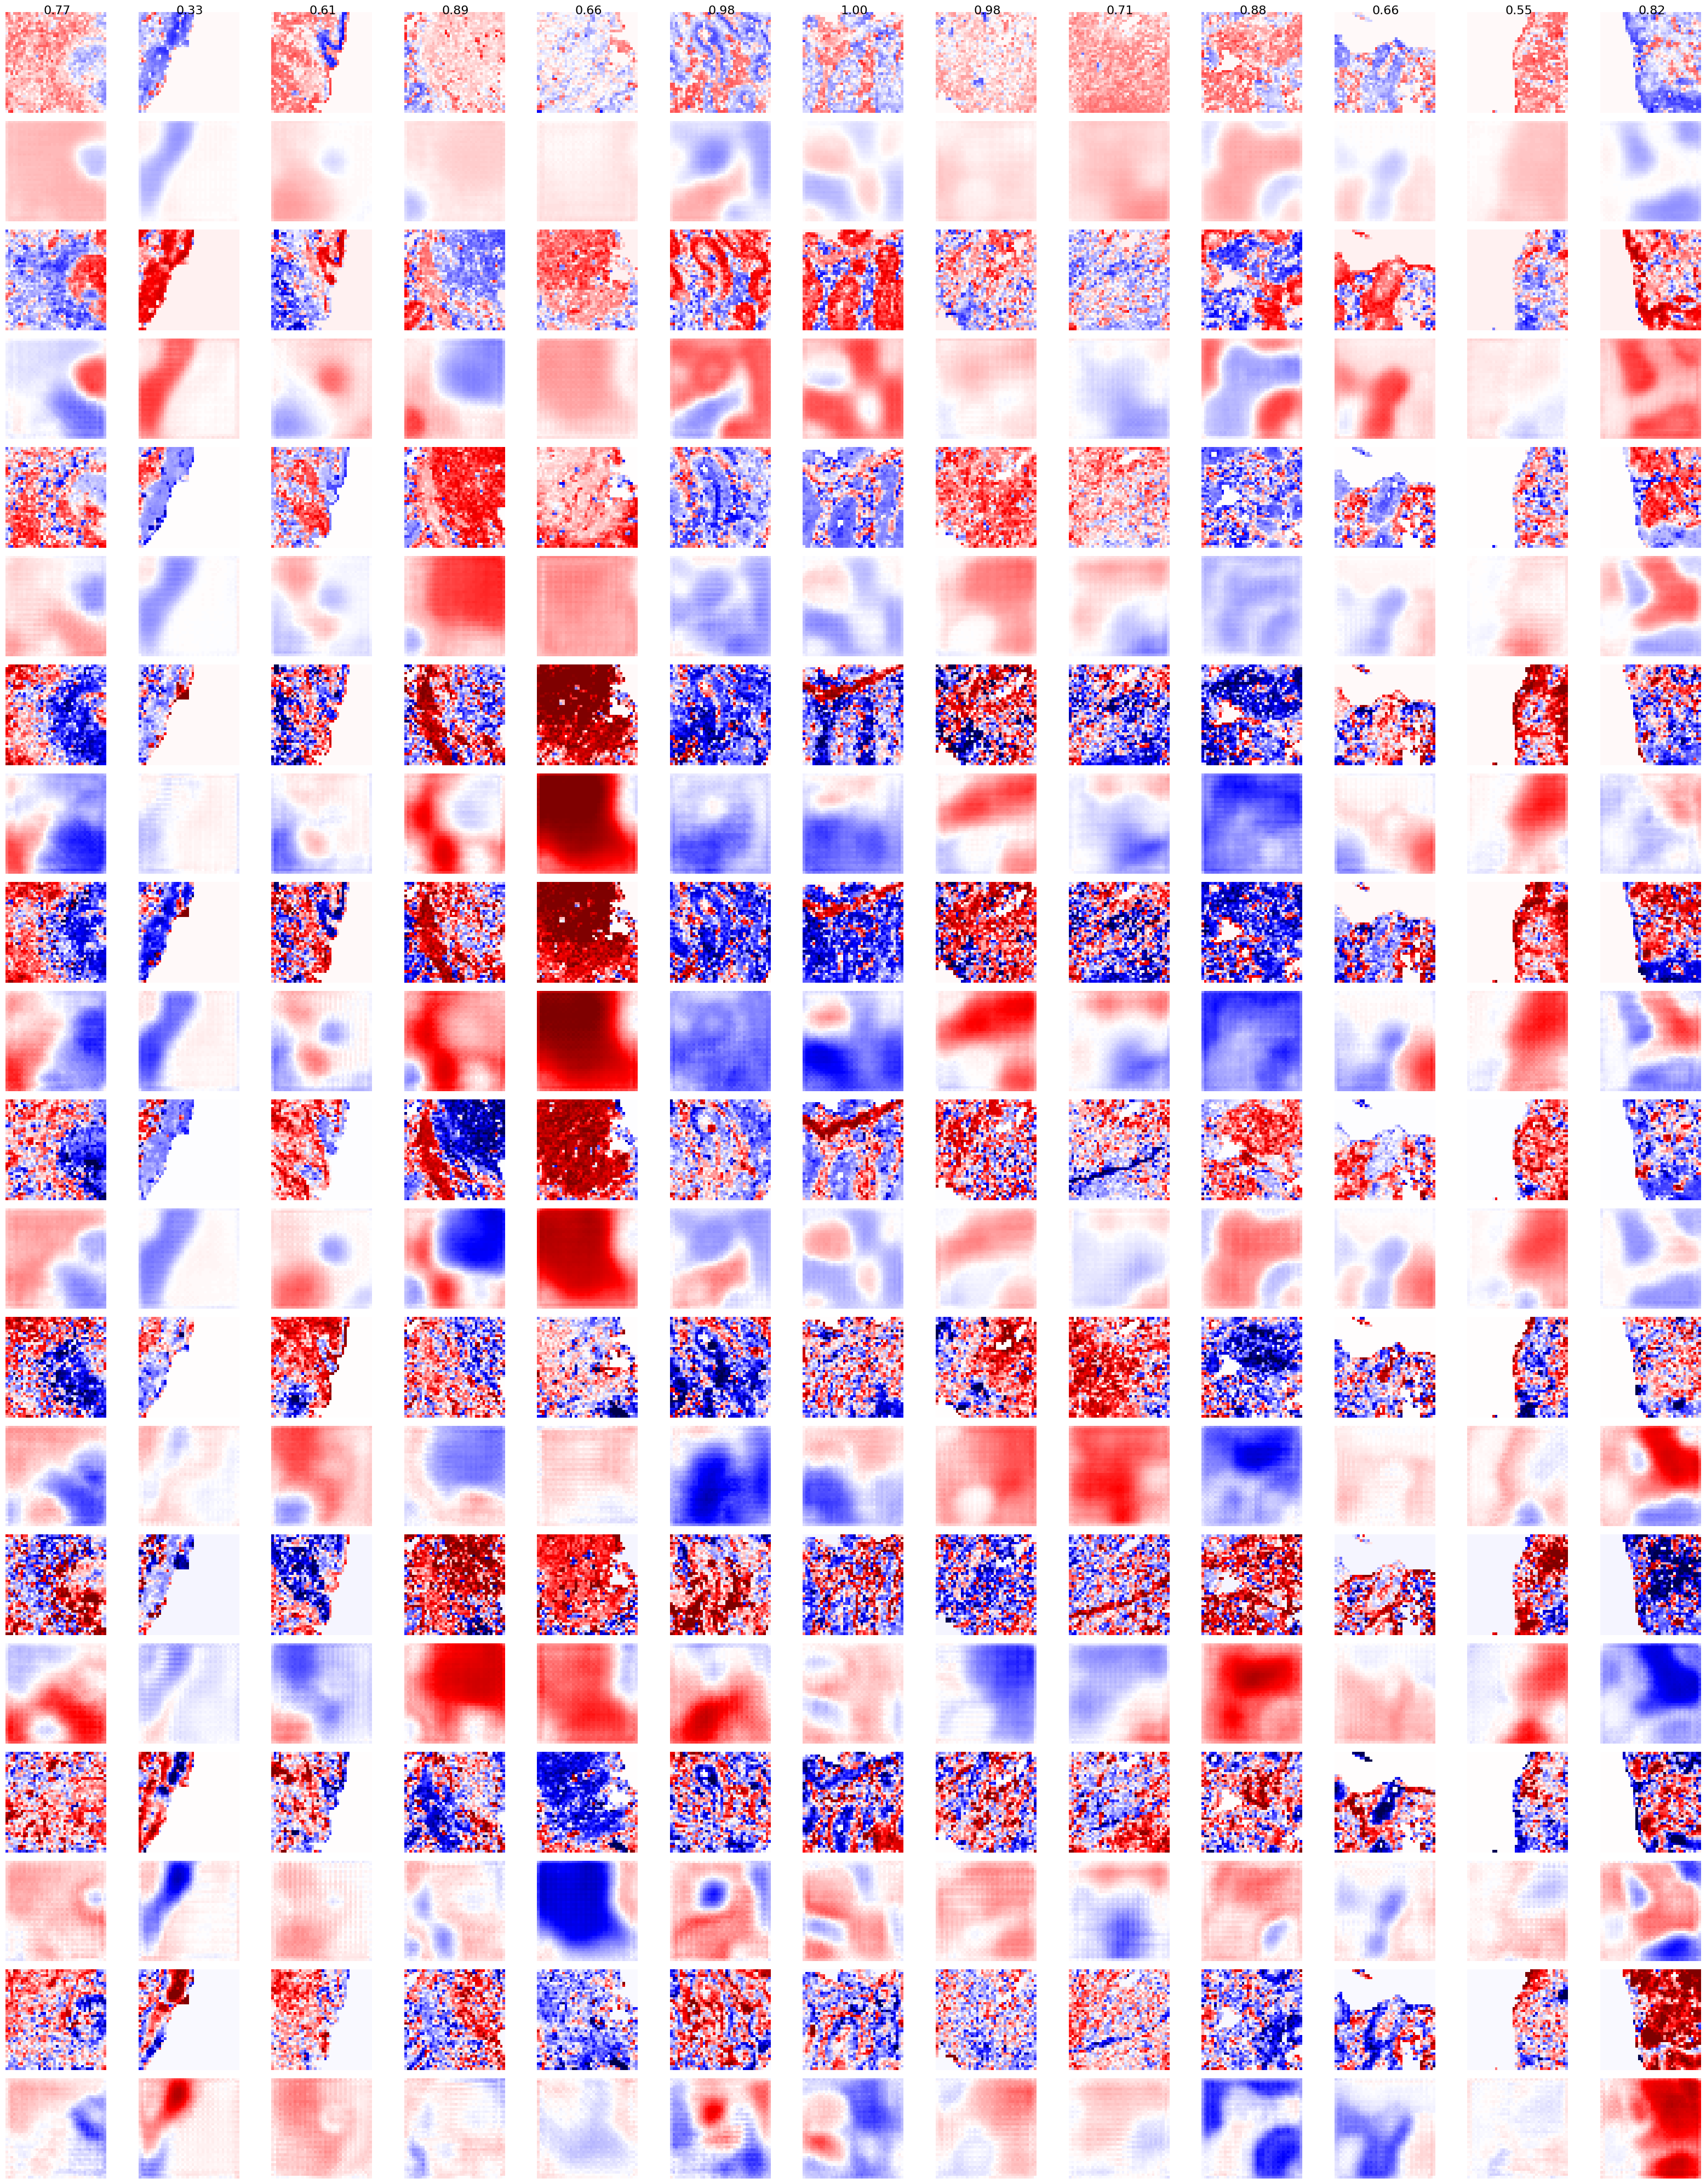

/n/data1/hms/dbmi/raychaudhuri/lab/lakshay/py/tpae/training.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path)) #

In [8]:
from importlib import reload; reload(tt)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model, losslogs = tt.full_training(model, train_dataset, val_dataset, optimizer, scheduler, batch_size=256, n_epochs=20,
                                kl_weight=kl_weight,
                                per_epoch_logging=tt.detailed_per_epoch_logging,
                                per_epoch_kwargs={'Pmin':P.vmin, 'Pmax':P.vmax})
torch.save(model.state_dict(), f'models/vae-{name}.pt')

In [9]:
model.load_state_dict(torch.load(f'models/vae-{name}.pt'))

/tmp/ipykernel_37780/1627040588.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/vae-{name}.pt'))


<All keys matched successfully>

in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.59it/s]


running UMAP


/home/sol121/.conda/envs/torch/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


built MultiAnnData object with sid as the unit of analysis


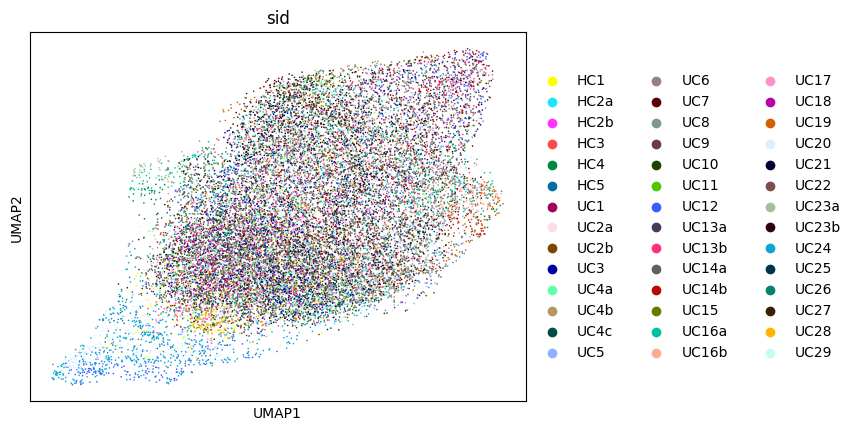

In [10]:
Ddense = ta.anndata(Pdense.meta,
                    ta.apply(model, Pdense, embedding=model.embedding),
                    samplemeta[samplemeta.donor.isin(Pdense.meta.donor.unique())],
                    sampleid='sid')
sc.pl.umap(Ddense, color='sid')

In [11]:
from importlib import reload; reload(cna)

Ddense.samplem = samplemeta
Ddense.samplem['Num_Status'] = Ddense.samplem['Status'].map({"healthy": 0., "UC": 1.})
Ddense.samplem.loc[(Ddense.samplem.TNFnow == 'y') | (Ddense.samplem.TNFprior == 'y'), 'Num_Status'] = np.nan
res = cna.tl.association(Ddense, Ddense.samplem.Num_Status, donorids=Ddense.samplem.donor.values, Nnull=10000)
# Ddense.samplem['yhat'] = res.yresid_hat
res.p, res.k

(0.0010998900109989002, 2)

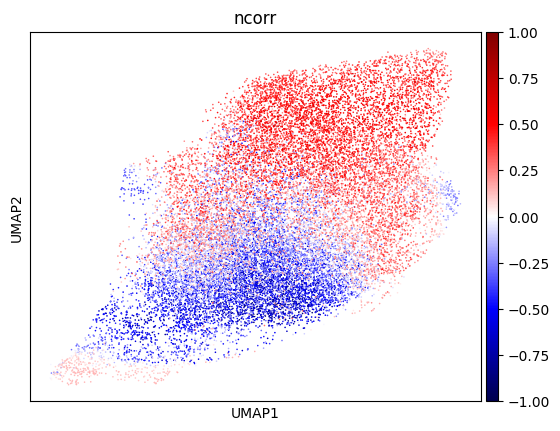

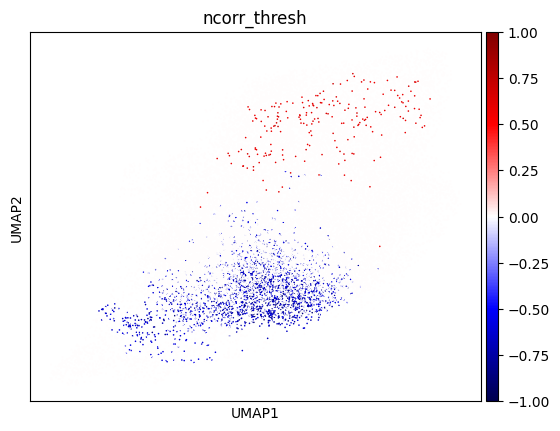

2400


In [12]:
t = res.fdrs[res.fdrs.threshold >= res.fdr_10p_t].iloc[0].threshold
d = Ddense
d.obs['ncorr'] = res.ncorrs
d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > t)
sc.pl.umap(d, color='ncorr', cmap='seismic', vmin=-1, vmax=1)
sc.pl.umap(d, color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1)
print((d.obs.ncorr_thresh != 0).sum())

# differential marker intensity

In [ ]:
def parser(fname):
    fname = fname.split('/')[-1].split('.')[0]
    if fname[-1].islower():
        donor = fname[:-1]
    else:
        donor = fname
    return {'sid':fname, 'donor':donor}
samples_m = tds.read_samples(f'../uc-data/10u/normalized/*.nc', parser)
Pdense_m = tdp.PatchCollection(Pdense.meta,
                        samples_m, standardize=True)

100%|███████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.26it/s]


in pytorch mode


In [ ]:
Pdense_m.numpy_mode()
patch_avgs = Pdense_m[:][0].mean(axis=(1,2))

In [ ]:
codexmarkers = samples_m['HC1'].marker.values
patch_avgs = pd.DataFrame(patch_avgs, columns=codexmarkers)
patch_avgs.index = patch_avgs.index.astype('str')
patch_avgs.index.name = 'index'
patch_avgs['ncorr_thresh'] = d.obs.ncorr_thresh

In [ ]:
# import seaborn as sns
marker_ratios = pd.DataFrame(index=codexmarkers, columns=['ratio'])
for m in codexmarkers:
    marker_ratios.loc[m, 'ratio'] = patch_avgs[Ddense.obs.ncorr_thresh > 0][m].median() -  patch_avgs[Ddense.obs.ncorr_thresh < 0][m].median()
marker_ratios = marker_ratios.sort_values(by='ratio')

df = pd.melt(patch_avgs, value_vars=marker_ratios[:10].index.values, var_name='marker', value_name='value', ignore_index=False)
df = df[patch_avgs.ncorr_thresh != 0]
df['healthy'] = patch_avgs.ncorr_thresh < 0
plt.figure(figsize=(14,4))
sns.violinplot(data=df, x='marker', y='value', hue='healthy')
plt.show()

df = pd.melt(patch_avgs, value_vars=marker_ratios.iloc[-10:].index.values, var_name='marker', value_name='value', ignore_index=False)
df = df[patch_avgs.ncorr_thresh != 0]
df['healthy'] = patch_avgs.ncorr_thresh < 0
plt.figure(figsize=(14,4))
sns.violinplot(data=df, x='marker', y='value', hue='healthy')
plt.show()

data augmentation is off
in numpy mode


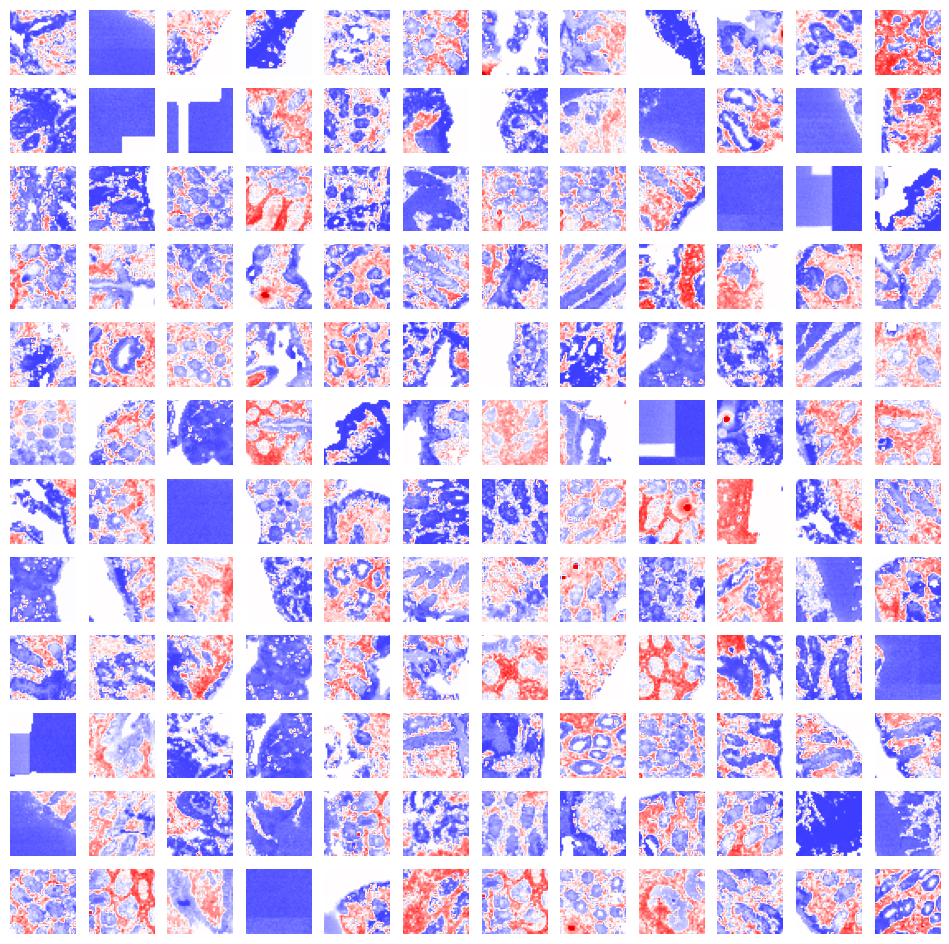

===


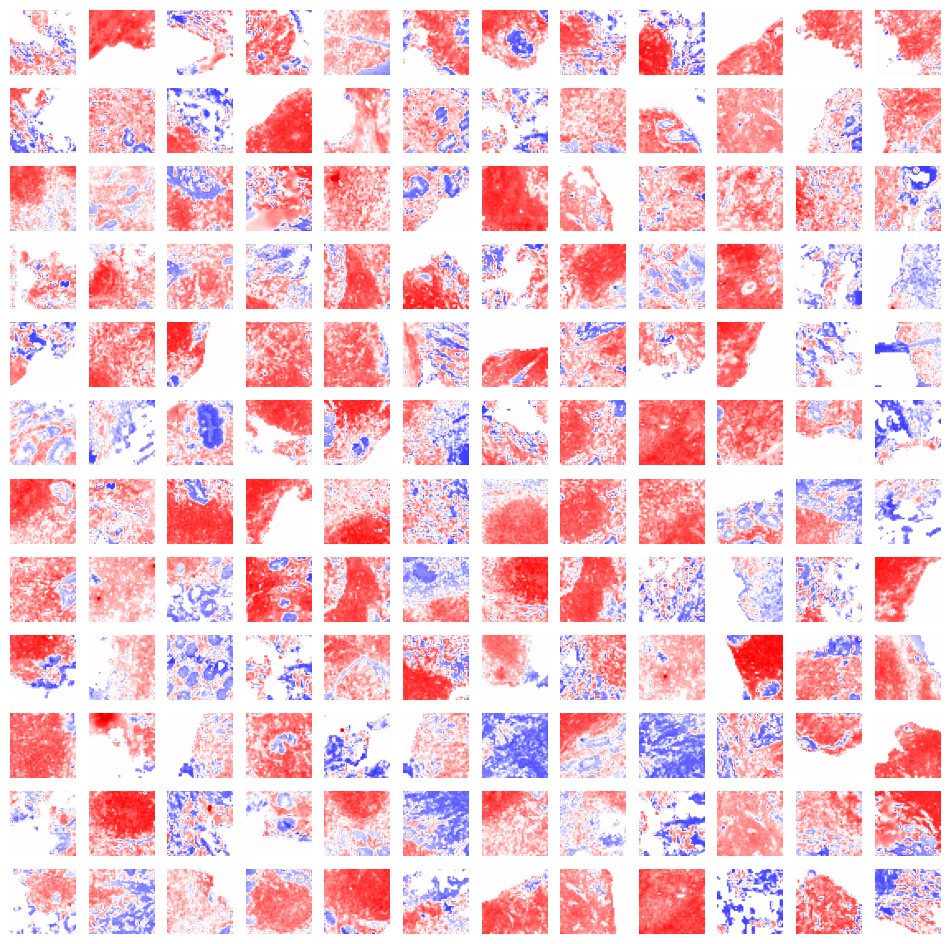

In [148]:
np.random.seed(0)
marker = 'CD45'
markerindex = np.where(codexmarkers == marker)[0][0]
ix = np.random.choice(d.obs[d.obs.ncorr_thresh < 0].index.astype(int).values, 144, replace=False)
ix_ = np.random.choice(d.obs[d.obs.ncorr_thresh > 0].index.astype(int).values, 144, replace=False)
Pdense_m.numpy_mode()

def plot_patches(pp, vmin=-1, vmax=1, ncols=8):
    nrows = int(np.ceil(len(pp)/ncols))
    f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    for ax, p in zip(axs.flatten(), pp):
        ax.imshow(p, cmap='seismic', vmin=vmin, vmax=vmax)
        ax.axis('off')
    plt.show()

zp = -Pdense_m.means[markerindex]/Pdense_m.stds[markerindex]
plot_patches(Pdense_m[ix][0][:,:,:,markerindex], vmin=zp-5, vmax=zp+5, ncols=12)
print('===')
plot_patches(Pdense_m[ix_][0][:,:,:,markerindex], vmin=zp-5, vmax=zp+5, ncols=12)

# rest

<Axes: >

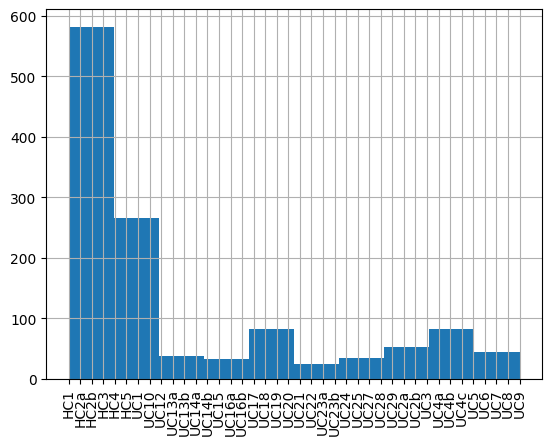

In [31]:
d_sub = d[d.obs['ncorr_thresh'] != 0]
d_sub.obs.sid.hist(xrot = 90)
# sc.pl.umap(d_sub, color = 'pheno')

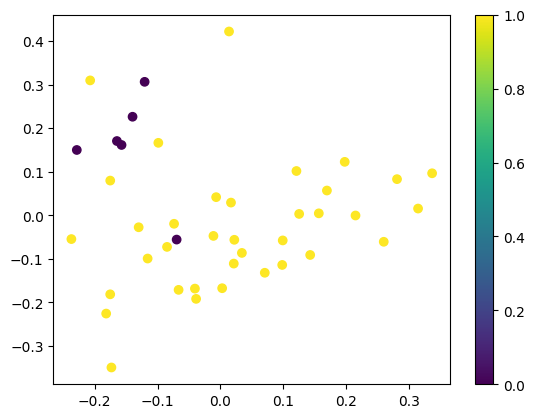

In [9]:
Ddense.samplem['PC1'] = Ddense.uns['NAM_sampleXpc'].PC1
Ddense.samplem['PC2'] = Ddense.uns['NAM_sampleXpc'].PC2
Ddense.samplem['PC3'] = Ddense.uns['NAM_sampleXpc'].PC3
mask = Ddense.samplem.Sex != '-'
plt.scatter(Ddense.samplem[mask].PC1, Ddense.samplem[mask].PC2, c=Ddense.samplem[mask].Status == 'UC')
plt.colorbar()
plt.show()

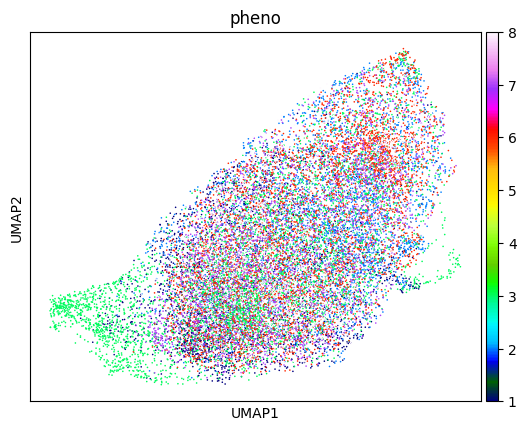

In [10]:
d.obs['pheno'] = pd.merge(d.obs, d.samplem, left_on='sid', right_index=True, how='left')['Run#']
sc.pl.umap(d, color='pheno', cmap='gist_ncar')

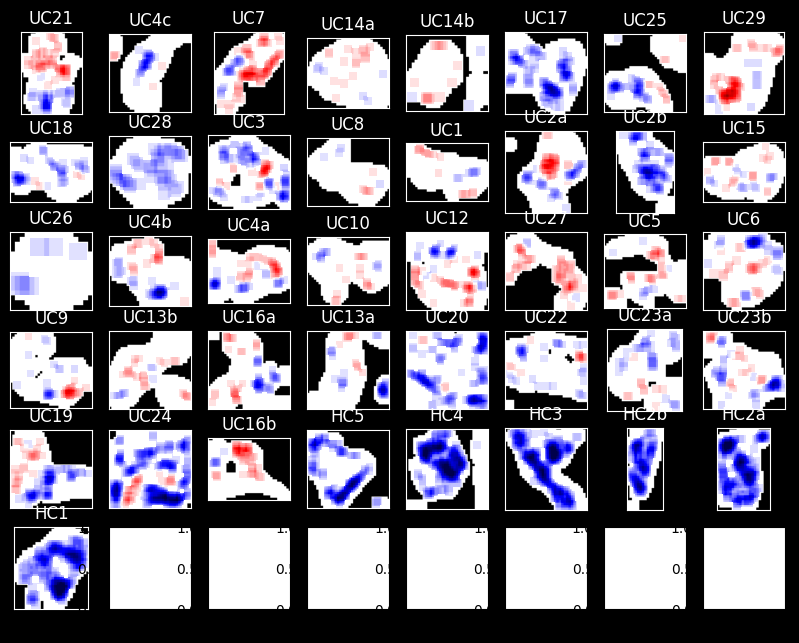

In [150]:
d = Ddense
fig, axs = plt.subplots(6,8, figsize=(10,6/8*10))
i = 0
for sid in d.samplem.Status.sort_values().index:
    mypatches = d[(d.obs.sid == sid)]
    mysigpatches = d[(d.obs.sid == sid)&(d.obs.ncorr_thresh != 0)]
    canvas = np.zeros_like(samples[sid][:,:,0])
    sigcanvas = np.zeros_like(samples[sid][:,:,0])
    for x,y,ps in mypatches.obs[['x','y','patchsize']].values:
        canvas[y:y+ps,x:x+ps] = 1
    for x,y,ps,nc in mysigpatches.obs[['x','y','patchsize','ncorr']].values:
        x,y,ps = int(x), int(y), int(ps)
        sigcanvas[y:y+ps,x:x+ps] += nc
    sigcanvas[sigcanvas == 0] = np.nan
    indices = np.where(canvas)
    nonempty_rows = canvas.sum(axis=1) > 0
    nonempty_cols = canvas.sum(axis=0) > 0
    if (~np.isnan(sigcanvas)).sum() > 0:
        ax = axs.flatten()[i]; i += 1
        ax.imshow(canvas[nonempty_rows][:,nonempty_cols], vmin=0, vmax=1, cmap='gray')
        ax.imshow(sigcanvas[nonempty_rows][:,nonempty_cols], vmin=-10, vmax=10, cmap='seismic')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_tick_params(length=0)
        ax.yaxis.set_tick_params(length=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(sid, color='white', fontsize=12)
fig.patch.set_facecolor('black')
plt.show()